# NBV Classification

In this notebook I train and validate the 3D CNN proposed by Mendoza et al. for Next Best View planning.

J. Irving Vasquez-Gomez
jivg.org

If our are using this code in your project please cite our paper:

> Mendoza, M., Vasquez-Gomez, J. I., Taud, H., Sucar, L. E., & Reta, C. (2019). Supervised Learning of the Next-Best-View for 3D Object Reconstruction. arXiv preprint arXiv:1905.05833.

In [1]:
# notebook configuration
display_dataset = True
display_fwd_pretraining = True
load_weights = False
reading_weights_file = 'weights/paper_param.pth'
saving_weights_file = 'log/weights.pth'
epochs = 1000
batch_size = 1000
learning_rate = 0.001
dropout_prob= 0.3

In [2]:
import numpy as np
import csv

import classification_nbv as cnbv
import nbvnet

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.nn as nn
from torch import optim

from torch.autograd import Variable

In [3]:
#check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [4]:
# save parameters used
params = {'epochs': epochs, 'batch_size': batch_size, 'learning_rate': learning_rate, 'dropout_prob': dropout_prob}

with open("log/parameters.csv", 'w') as csvfile:
    fieldnames = params.keys()  #['first_name', 'last_name', 'Grade']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
 
    writer.writeheader()
    writer.writerow(params)

## Dataset Preprocessing

In [5]:
# Read the pose that corresponds to a class.
nbv_positions = np.genfromtxt('points_in_sphere.txt')

# This function converts a class to its corresponding pose
def getPosition(nbv_class, nbv_positions):
    return nbv_positions[nbv_class]
            

In [6]:
training_dataset = cnbv.NBVClassificationDatasetFull(grid_file='../dataset/classification/training/dataset_vol_classification_training.npy', 
                                    nbv_class_file='../dataset/classification/training/dataset_lbl_classification_training.npy',
                                    transform=transforms.Compose([
                                    # Reshapes the plain grid
                                    cnbv.To3DGrid(),
                                    #converts to tensors
                                    cnbv.ToTensor()
                                    ]))

validation_dataset = cnbv.NBVClassificationDatasetFull(grid_file='../dataset/classification/validation/dataset_vol_classification_validation.npy', 
                                    nbv_class_file='../dataset/classification/validation/dataset_lbl_classification_validation.npy',
                                    transform=transforms.Compose([
                                    # Reshapes the plain grid
                                    cnbv.To3DGrid(),
                                    #converts to tensors
                                    cnbv.ToTensor()
                                    ]))

   

Training dataset lenght:10764
Validation dataset lenght:2691
0 torch.Size([1, 32, 32, 32]) torch.Size([])


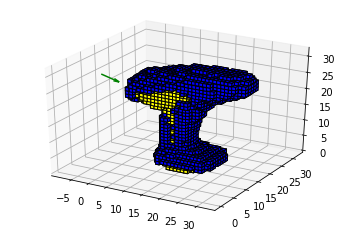

1 torch.Size([1, 32, 32, 32]) torch.Size([])


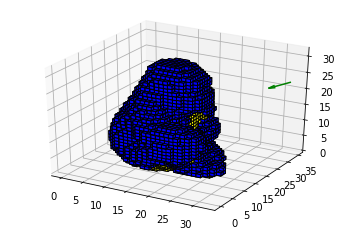

2 torch.Size([1, 32, 32, 32]) torch.Size([])


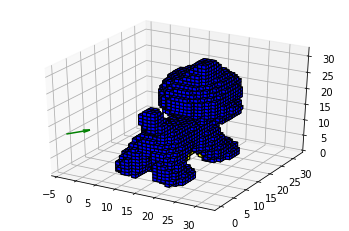

3 torch.Size([1, 32, 32, 32]) torch.Size([])


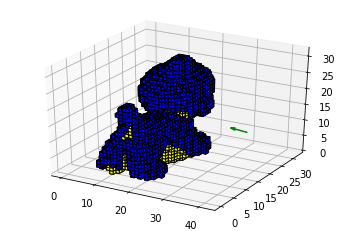

In [7]:
print('Training dataset lenght:' + str(len(training_dataset)))
print('Validation dataset lenght:' + str(len(validation_dataset)))

for i in range(len(training_dataset)):
    sample = training_dataset[i]

    print(i, sample['grid'].size(), sample['nbv_class'].size())
    
    if display_dataset:
        #print(sample['nbv_class'].numpy())
        nbv = getPosition(sample['nbv_class'].numpy(), nbv_positions)
        nbv = np.squeeze(nbv)
        #print(nbv)
        cnbv.showGrid(sample['grid'].numpy(), nbv)
    
    if i == 3:
        break

In [8]:
# load training data in batches
train_loader = DataLoader(training_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

validation_loader = DataLoader(validation_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## NBV-Net

NBV net:

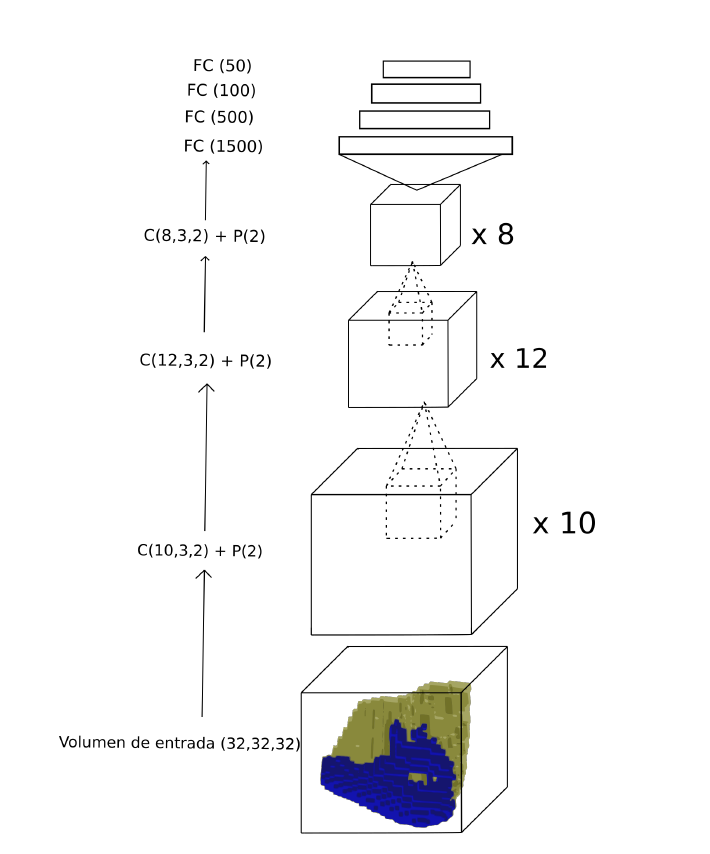

In [9]:
net = nbvnet.NBV_Net(dropout_prob)
net.to(device)
print(net)

NBV_Net(
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(10, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(12, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_drop): Dropout(p=0.3)
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=1500, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=1500, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.3)
  (fc3): Linear(in_features=500, out_features=100, bias=True)
  (fc3_drop): Dropout(p=0.3)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc4_drop): Dropout(p=0.3)
  (fc5): Linear(in_features=50, o

In [10]:
# Weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        m.weight.data.normal_(0.0, 0.1)
        m.bias.data.fill_(0)
        
net.apply(weights_init)

NBV_Net(
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(10, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(12, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_drop): Dropout(p=0.3)
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=1500, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=1500, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.3)
  (fc3): Linear(in_features=500, out_features=100, bias=True)
  (fc3_drop): Dropout(p=0.3)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc4_drop): Dropout(p=0.3)
  (fc5): Linear(in_features=50, o

In [11]:
# weights load
if load_weights:
    state_dict = torch.load(reading_weights_file)
    #print(state_dict.keys())
    net.load_state_dict(state_dict)

In [12]:
# test the model on a batch of test grids
def net_sample_output():
    net.eval()
    
    # iterate through the test dataset
    for i, sample in enumerate(train_loader):
        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']

        # convert images to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)

        # forward pass to get net output
        output = net(grids)
        grids = grids.cpu()
        output = output.cpu()
        
        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(output.data, 1)

        # break after first image is tested
        if i == 0:
            return grids, predicted, nbvs

In [13]:
# call the function that test the model on a batch
# returns: test images, test predicted keypoints, test ground truth keypoints
test_grids, test_outputs, gt_nbvs = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_grids.data.size())
print(test_outputs.data.size())
#print(test_outputs)
print(gt_nbvs.size())
#print(gt_nbvs)

torch.Size([1000, 1, 32, 32, 32])
torch.Size([1000])
torch.Size([1000])


In [14]:
# helpful function that displays the octree and the nbv
def visualize_output(test_grids, test_outputs, gt_nbvs=None, batch_size=batch_size):

    for i in range(batch_size):

        # un-transform the image data
        grid = test_grids[i].data   # get the image from it's wrapper
        grid = grid.numpy()   # convert to numpy array from a Tensor

        print(test_outputs[i].data.numpy())
        # un-transform the predicted nbv
        predicted = getPosition( test_outputs[i].data.numpy(), nbv_positions)
        #print(predicted)
        
        print(gt_nbvs[i].numpy())
        gt = getPosition(gt_nbvs[i].numpy(), nbv_positions)
        #print(gt)
        
        cnbv.showGrid(grid, gt, predicted)
        #plt.show()
        
        if i==2:
            break

7
4


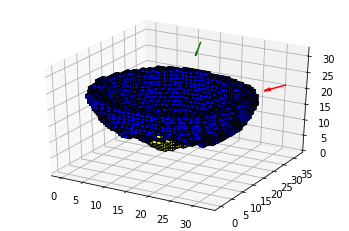

7
5


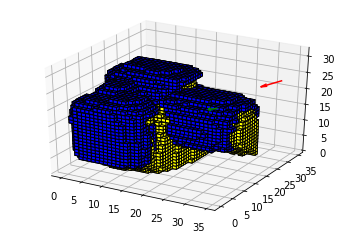

7
6


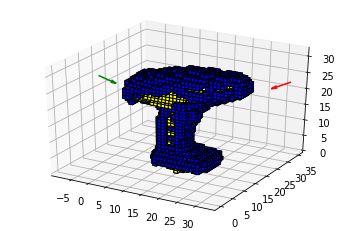

In [15]:
visualize_output(test_grids, test_outputs, np.squeeze(gt_nbvs))

## Training

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= learning_rate)

In [17]:
# Validation Function
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for sample in testloader:
        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']
        
        # convert images to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)
        
        # wrap them in a torch Variable
        nbvs = Variable(nbvs) 
        nbvs = nbvs.to(device)

        output = model.forward(grids)
        test_loss += criterion(output, nbvs).item()

        # for log.  ps = torch.exp(output)
        equality = (nbvs.data == output.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [18]:
# Training loop
running_loss = 0
save_after = 100

history_epoch = []
history_train_loss = []
history_validation_loss = []
history_train_accuracy = []
history_validation_accuracy = []

import time
tic = time.clock()

for e in range(epochs):
    # Cambiamos a modo entrenamiento
    net.train()
    
    for i, sample in enumerate(train_loader):        
        # get sample data: images and ground truth keypoints
        grids = sample['grid']
        nbvs = sample['nbv_class']

        # convert grids to FloatTensors
        grids = grids.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        grids = Variable(grids)    
        grids = grids.to(device)
        
        # wrap them in a torch Variable
        nbvs = Variable(nbvs) 
        nbvs = nbvs.to(device)
        
        optimizer.zero_grad()

        # forward pass to get net output
        output = net(grids)
        
        #ot = output.cpu()
        #print(ot)    
        
        loss = criterion(output, nbvs)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
            
    
    # Cambiamos a modo de evaluación
    net.eval()
            
    # Apagamos los gradientes, reduce memoria y cálculos
    with torch.no_grad():
        train_loss, train_accuracy = validation(net, train_loader, criterion)
        val_loss, val_accuracy = validation(net, validation_loader, criterion)
        
        train_loss, train_accuracy = train_loss, train_accuracy.cpu().numpy()
        val_loss, val_accuracy = val_loss, val_accuracy.cpu().numpy()
        
        train_accuracy = train_accuracy / len(train_loader)
        val_accuracy = val_accuracy / len(validation_loader)
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Val. Loss: {:.3f}.. ".format(val_loss),
              "Train Accuracy: {:.3f}".format(train_accuracy),
              "Val. Accuracy: {:.3f}".format(val_accuracy))
    
    history_epoch.append(e)
    history_train_loss.append(train_loss)
    history_validation_loss.append(val_loss)
    history_train_accuracy.append(train_accuracy)
    history_validation_accuracy.append(val_accuracy)
    
    running_loss = 0
    
    if(e % save_after == 0):
        np.save('log/train_loss'+str(e), history_train_loss)
        np.save('log/validation_loss'+str(e), history_validation_loss)
        np.save('log/train_accuracy'+str(e), history_train_accuracy)
        np.save('log/validation_accuracy'+str(e), history_validation_accuracy)
        torch.save(net.state_dict(), 'log/weights'+str(e)+'.pth')
    
    # Make sure training is back on
    net.train()
    
toc = time.clock()
print(toc - tic)

Epoch: 1/1000..  Training Loss: 28.877..  Val. Loss: 7.867..  Train Accuracy: 0.134 Val. Accuracy: 0.139
Epoch: 2/1000..  Training Loss: 28.760..  Val. Loss: 7.821..  Train Accuracy: 0.114 Val. Accuracy: 0.122
Epoch: 3/1000..  Training Loss: 28.779..  Val. Loss: 7.839..  Train Accuracy: 0.118 Val. Accuracy: 0.123
Epoch: 4/1000..  Training Loss: 28.683..  Val. Loss: 7.802..  Train Accuracy: 0.134 Val. Accuracy: 0.149
Epoch: 5/1000..  Training Loss: 28.610..  Val. Loss: 7.784..  Train Accuracy: 0.136 Val. Accuracy: 0.148
Epoch: 6/1000..  Training Loss: 28.518..  Val. Loss: 7.759..  Train Accuracy: 0.142 Val. Accuracy: 0.145
Epoch: 7/1000..  Training Loss: 28.416..  Val. Loss: 7.743..  Train Accuracy: 0.158 Val. Accuracy: 0.158
Epoch: 8/1000..  Training Loss: 28.338..  Val. Loss: 7.724..  Train Accuracy: 0.164 Val. Accuracy: 0.162
Epoch: 9/1000..  Training Loss: 28.261..  Val. Loss: 7.700..  Train Accuracy: 0.176 Val. Accuracy: 0.182
Epoch: 10/1000..  Training Loss: 28.279..  Val. Loss: 7

Epoch: 79/1000..  Training Loss: 26.418..  Val. Loss: 7.189..  Train Accuracy: 0.352 Val. Accuracy: 0.359
Epoch: 80/1000..  Training Loss: 26.408..  Val. Loss: 7.220..  Train Accuracy: 0.352 Val. Accuracy: 0.347
Epoch: 81/1000..  Training Loss: 26.432..  Val. Loss: 7.218..  Train Accuracy: 0.353 Val. Accuracy: 0.349
Epoch: 82/1000..  Training Loss: 26.350..  Val. Loss: 7.196..  Train Accuracy: 0.361 Val. Accuracy: 0.357
Epoch: 83/1000..  Training Loss: 26.261..  Val. Loss: 7.166..  Train Accuracy: 0.370 Val. Accuracy: 0.369
Epoch: 84/1000..  Training Loss: 26.289..  Val. Loss: 7.164..  Train Accuracy: 0.366 Val. Accuracy: 0.369
Epoch: 85/1000..  Training Loss: 26.331..  Val. Loss: 7.178..  Train Accuracy: 0.361 Val. Accuracy: 0.361
Epoch: 86/1000..  Training Loss: 26.293..  Val. Loss: 7.163..  Train Accuracy: 0.365 Val. Accuracy: 0.367
Epoch: 87/1000..  Training Loss: 26.320..  Val. Loss: 7.188..  Train Accuracy: 0.362 Val. Accuracy: 0.358
Epoch: 88/1000..  Training Loss: 26.203..  Val

Epoch: 156/1000..  Training Loss: 25.522..  Val. Loss: 7.034..  Train Accuracy: 0.433 Val. Accuracy: 0.410
Epoch: 157/1000..  Training Loss: 25.463..  Val. Loss: 7.006..  Train Accuracy: 0.439 Val. Accuracy: 0.418
Epoch: 158/1000..  Training Loss: 25.531..  Val. Loss: 7.008..  Train Accuracy: 0.433 Val. Accuracy: 0.419
Epoch: 159/1000..  Training Loss: 25.414..  Val. Loss: 6.981..  Train Accuracy: 0.443 Val. Accuracy: 0.427
Epoch: 160/1000..  Training Loss: 25.434..  Val. Loss: 6.977..  Train Accuracy: 0.441 Val. Accuracy: 0.429
Epoch: 161/1000..  Training Loss: 25.435..  Val. Loss: 6.978..  Train Accuracy: 0.441 Val. Accuracy: 0.426
Epoch: 162/1000..  Training Loss: 25.493..  Val. Loss: 7.004..  Train Accuracy: 0.436 Val. Accuracy: 0.419
Epoch: 163/1000..  Training Loss: 25.423..  Val. Loss: 6.982..  Train Accuracy: 0.442 Val. Accuracy: 0.426
Epoch: 164/1000..  Training Loss: 25.394..  Val. Loss: 6.988..  Train Accuracy: 0.445 Val. Accuracy: 0.424
Epoch: 165/1000..  Training Loss: 25.

Epoch: 233/1000..  Training Loss: 24.824..  Val. Loss: 6.915..  Train Accuracy: 0.498 Val. Accuracy: 0.449
Epoch: 234/1000..  Training Loss: 24.931..  Val. Loss: 6.937..  Train Accuracy: 0.487 Val. Accuracy: 0.442
Epoch: 235/1000..  Training Loss: 24.863..  Val. Loss: 6.899..  Train Accuracy: 0.492 Val. Accuracy: 0.454
Epoch: 236/1000..  Training Loss: 24.903..  Val. Loss: 6.918..  Train Accuracy: 0.490 Val. Accuracy: 0.448
Epoch: 237/1000..  Training Loss: 24.912..  Val. Loss: 6.913..  Train Accuracy: 0.488 Val. Accuracy: 0.451
Epoch: 238/1000..  Training Loss: 24.896..  Val. Loss: 6.904..  Train Accuracy: 0.490 Val. Accuracy: 0.453
Epoch: 239/1000..  Training Loss: 24.916..  Val. Loss: 6.904..  Train Accuracy: 0.489 Val. Accuracy: 0.452
Epoch: 240/1000..  Training Loss: 24.852..  Val. Loss: 6.899..  Train Accuracy: 0.494 Val. Accuracy: 0.454
Epoch: 241/1000..  Training Loss: 24.853..  Val. Loss: 6.892..  Train Accuracy: 0.494 Val. Accuracy: 0.457
Epoch: 242/1000..  Training Loss: 24.

Epoch: 310/1000..  Training Loss: 24.239..  Val. Loss: 6.824..  Train Accuracy: 0.550 Val. Accuracy: 0.479
Epoch: 311/1000..  Training Loss: 24.280..  Val. Loss: 6.845..  Train Accuracy: 0.547 Val. Accuracy: 0.472
Epoch: 312/1000..  Training Loss: 24.162..  Val. Loss: 6.823..  Train Accuracy: 0.557 Val. Accuracy: 0.480
Epoch: 313/1000..  Training Loss: 24.130..  Val. Loss: 6.816..  Train Accuracy: 0.561 Val. Accuracy: 0.482
Epoch: 314/1000..  Training Loss: 24.203..  Val. Loss: 6.822..  Train Accuracy: 0.554 Val. Accuracy: 0.479
Epoch: 315/1000..  Training Loss: 24.253..  Val. Loss: 6.843..  Train Accuracy: 0.550 Val. Accuracy: 0.473
Epoch: 316/1000..  Training Loss: 24.157..  Val. Loss: 6.810..  Train Accuracy: 0.558 Val. Accuracy: 0.483
Epoch: 317/1000..  Training Loss: 24.117..  Val. Loss: 6.795..  Train Accuracy: 0.562 Val. Accuracy: 0.489
Epoch: 318/1000..  Training Loss: 24.144..  Val. Loss: 6.795..  Train Accuracy: 0.559 Val. Accuracy: 0.488
Epoch: 319/1000..  Training Loss: 24.

Epoch: 387/1000..  Training Loss: 23.844..  Val. Loss: 6.782..  Train Accuracy: 0.587 Val. Accuracy: 0.493
Epoch: 388/1000..  Training Loss: 23.865..  Val. Loss: 6.761..  Train Accuracy: 0.584 Val. Accuracy: 0.501
Epoch: 389/1000..  Training Loss: 23.858..  Val. Loss: 6.765..  Train Accuracy: 0.585 Val. Accuracy: 0.499
Epoch: 390/1000..  Training Loss: 23.864..  Val. Loss: 6.786..  Train Accuracy: 0.584 Val. Accuracy: 0.492
Epoch: 391/1000..  Training Loss: 23.842..  Val. Loss: 6.786..  Train Accuracy: 0.587 Val. Accuracy: 0.491
Epoch: 392/1000..  Training Loss: 23.854..  Val. Loss: 6.773..  Train Accuracy: 0.585 Val. Accuracy: 0.496
Epoch: 393/1000..  Training Loss: 23.862..  Val. Loss: 6.784..  Train Accuracy: 0.585 Val. Accuracy: 0.492
Epoch: 394/1000..  Training Loss: 23.784..  Val. Loss: 6.763..  Train Accuracy: 0.591 Val. Accuracy: 0.498
Epoch: 395/1000..  Training Loss: 23.955..  Val. Loss: 6.775..  Train Accuracy: 0.576 Val. Accuracy: 0.495
Epoch: 396/1000..  Training Loss: 23.

Epoch: 464/1000..  Training Loss: 23.609..  Val. Loss: 6.749..  Train Accuracy: 0.607 Val. Accuracy: 0.504
Epoch: 465/1000..  Training Loss: 23.633..  Val. Loss: 6.735..  Train Accuracy: 0.605 Val. Accuracy: 0.510
Epoch: 466/1000..  Training Loss: 23.622..  Val. Loss: 6.757..  Train Accuracy: 0.606 Val. Accuracy: 0.501
Epoch: 467/1000..  Training Loss: 23.690..  Val. Loss: 6.757..  Train Accuracy: 0.600 Val. Accuracy: 0.502
Epoch: 468/1000..  Training Loss: 23.660..  Val. Loss: 6.745..  Train Accuracy: 0.603 Val. Accuracy: 0.505
Epoch: 469/1000..  Training Loss: 23.599..  Val. Loss: 6.730..  Train Accuracy: 0.609 Val. Accuracy: 0.510
Epoch: 470/1000..  Training Loss: 23.691..  Val. Loss: 6.745..  Train Accuracy: 0.600 Val. Accuracy: 0.507
Epoch: 471/1000..  Training Loss: 23.608..  Val. Loss: 6.746..  Train Accuracy: 0.608 Val. Accuracy: 0.505
Epoch: 472/1000..  Training Loss: 23.627..  Val. Loss: 6.744..  Train Accuracy: 0.605 Val. Accuracy: 0.505
Epoch: 473/1000..  Training Loss: 23.

Epoch: 541/1000..  Training Loss: 23.375..  Val. Loss: 6.728..  Train Accuracy: 0.628 Val. Accuracy: 0.511
Epoch: 542/1000..  Training Loss: 23.390..  Val. Loss: 6.746..  Train Accuracy: 0.627 Val. Accuracy: 0.505
Epoch: 543/1000..  Training Loss: 23.405..  Val. Loss: 6.752..  Train Accuracy: 0.626 Val. Accuracy: 0.503
Epoch: 544/1000..  Training Loss: 23.471..  Val. Loss: 6.710..  Train Accuracy: 0.620 Val. Accuracy: 0.517
Epoch: 545/1000..  Training Loss: 23.412..  Val. Loss: 6.731..  Train Accuracy: 0.625 Val. Accuracy: 0.510
Epoch: 546/1000..  Training Loss: 23.368..  Val. Loss: 6.700..  Train Accuracy: 0.629 Val. Accuracy: 0.520
Epoch: 547/1000..  Training Loss: 23.412..  Val. Loss: 6.736..  Train Accuracy: 0.625 Val. Accuracy: 0.507
Epoch: 548/1000..  Training Loss: 23.422..  Val. Loss: 6.729..  Train Accuracy: 0.624 Val. Accuracy: 0.510
Epoch: 549/1000..  Training Loss: 23.364..  Val. Loss: 6.723..  Train Accuracy: 0.629 Val. Accuracy: 0.511
Epoch: 550/1000..  Training Loss: 23.

Epoch: 618/1000..  Training Loss: 23.146..  Val. Loss: 6.722..  Train Accuracy: 0.649 Val. Accuracy: 0.512
Epoch: 619/1000..  Training Loss: 23.164..  Val. Loss: 6.697..  Train Accuracy: 0.647 Val. Accuracy: 0.522
Epoch: 620/1000..  Training Loss: 23.249..  Val. Loss: 6.703..  Train Accuracy: 0.639 Val. Accuracy: 0.519
Epoch: 621/1000..  Training Loss: 23.210..  Val. Loss: 6.714..  Train Accuracy: 0.643 Val. Accuracy: 0.517
Epoch: 622/1000..  Training Loss: 23.194..  Val. Loss: 6.703..  Train Accuracy: 0.645 Val. Accuracy: 0.519
Epoch: 623/1000..  Training Loss: 23.229..  Val. Loss: 6.730..  Train Accuracy: 0.641 Val. Accuracy: 0.509
Epoch: 624/1000..  Training Loss: 23.182..  Val. Loss: 6.710..  Train Accuracy: 0.646 Val. Accuracy: 0.517
Epoch: 625/1000..  Training Loss: 23.154..  Val. Loss: 6.697..  Train Accuracy: 0.648 Val. Accuracy: 0.522
Epoch: 626/1000..  Training Loss: 23.157..  Val. Loss: 6.728..  Train Accuracy: 0.648 Val. Accuracy: 0.512
Epoch: 627/1000..  Training Loss: 23.

Epoch: 695/1000..  Training Loss: 23.121..  Val. Loss: 6.712..  Train Accuracy: 0.651 Val. Accuracy: 0.516
Epoch: 696/1000..  Training Loss: 23.168..  Val. Loss: 6.745..  Train Accuracy: 0.647 Val. Accuracy: 0.506
Epoch: 697/1000..  Training Loss: 23.114..  Val. Loss: 6.725..  Train Accuracy: 0.652 Val. Accuracy: 0.511
Epoch: 698/1000..  Training Loss: 23.100..  Val. Loss: 6.723..  Train Accuracy: 0.654 Val. Accuracy: 0.512
Epoch: 699/1000..  Training Loss: 23.084..  Val. Loss: 6.734..  Train Accuracy: 0.655 Val. Accuracy: 0.508
Epoch: 700/1000..  Training Loss: 23.037..  Val. Loss: 6.711..  Train Accuracy: 0.659 Val. Accuracy: 0.516
Epoch: 701/1000..  Training Loss: 23.061..  Val. Loss: 6.712..  Train Accuracy: 0.656 Val. Accuracy: 0.516
Epoch: 702/1000..  Training Loss: 23.025..  Val. Loss: 6.684..  Train Accuracy: 0.660 Val. Accuracy: 0.526
Epoch: 703/1000..  Training Loss: 23.059..  Val. Loss: 6.703..  Train Accuracy: 0.657 Val. Accuracy: 0.519
Epoch: 704/1000..  Training Loss: 23.

Epoch: 772/1000..  Training Loss: 22.972..  Val. Loss: 6.704..  Train Accuracy: 0.665 Val. Accuracy: 0.519
Epoch: 773/1000..  Training Loss: 22.964..  Val. Loss: 6.705..  Train Accuracy: 0.666 Val. Accuracy: 0.517
Epoch: 774/1000..  Training Loss: 23.005..  Val. Loss: 6.716..  Train Accuracy: 0.662 Val. Accuracy: 0.515
Epoch: 775/1000..  Training Loss: 22.926..  Val. Loss: 6.700..  Train Accuracy: 0.669 Val. Accuracy: 0.520
Epoch: 776/1000..  Training Loss: 22.973..  Val. Loss: 6.703..  Train Accuracy: 0.665 Val. Accuracy: 0.519
Epoch: 777/1000..  Training Loss: 23.010..  Val. Loss: 6.702..  Train Accuracy: 0.661 Val. Accuracy: 0.519
Epoch: 778/1000..  Training Loss: 22.987..  Val. Loss: 6.694..  Train Accuracy: 0.663 Val. Accuracy: 0.523
Epoch: 779/1000..  Training Loss: 22.928..  Val. Loss: 6.700..  Train Accuracy: 0.669 Val. Accuracy: 0.521
Epoch: 780/1000..  Training Loss: 22.937..  Val. Loss: 6.721..  Train Accuracy: 0.667 Val. Accuracy: 0.514
Epoch: 781/1000..  Training Loss: 23.

Epoch: 849/1000..  Training Loss: 22.858..  Val. Loss: 6.672..  Train Accuracy: 0.675 Val. Accuracy: 0.529
Epoch: 850/1000..  Training Loss: 22.908..  Val. Loss: 6.704..  Train Accuracy: 0.671 Val. Accuracy: 0.520
Epoch: 851/1000..  Training Loss: 22.866..  Val. Loss: 6.725..  Train Accuracy: 0.674 Val. Accuracy: 0.512
Epoch: 852/1000..  Training Loss: 22.922..  Val. Loss: 6.696..  Train Accuracy: 0.669 Val. Accuracy: 0.520
Epoch: 853/1000..  Training Loss: 22.941..  Val. Loss: 6.704..  Train Accuracy: 0.667 Val. Accuracy: 0.518
Epoch: 854/1000..  Training Loss: 23.011..  Val. Loss: 6.712..  Train Accuracy: 0.661 Val. Accuracy: 0.515
Epoch: 855/1000..  Training Loss: 22.920..  Val. Loss: 6.693..  Train Accuracy: 0.669 Val. Accuracy: 0.522
Epoch: 856/1000..  Training Loss: 22.950..  Val. Loss: 6.695..  Train Accuracy: 0.666 Val. Accuracy: 0.522
Epoch: 857/1000..  Training Loss: 22.899..  Val. Loss: 6.672..  Train Accuracy: 0.671 Val. Accuracy: 0.529
Epoch: 858/1000..  Training Loss: 22.

Epoch: 926/1000..  Training Loss: 22.831..  Val. Loss: 6.680..  Train Accuracy: 0.677 Val. Accuracy: 0.526
Epoch: 927/1000..  Training Loss: 22.816..  Val. Loss: 6.689..  Train Accuracy: 0.678 Val. Accuracy: 0.524
Epoch: 928/1000..  Training Loss: 22.844..  Val. Loss: 6.678..  Train Accuracy: 0.676 Val. Accuracy: 0.527
Epoch: 929/1000..  Training Loss: 22.826..  Val. Loss: 6.690..  Train Accuracy: 0.677 Val. Accuracy: 0.522
Epoch: 930/1000..  Training Loss: 22.832..  Val. Loss: 6.705..  Train Accuracy: 0.677 Val. Accuracy: 0.518
Epoch: 931/1000..  Training Loss: 22.871..  Val. Loss: 6.688..  Train Accuracy: 0.673 Val. Accuracy: 0.523
Epoch: 932/1000..  Training Loss: 22.834..  Val. Loss: 6.672..  Train Accuracy: 0.677 Val. Accuracy: 0.529
Epoch: 933/1000..  Training Loss: 22.821..  Val. Loss: 6.690..  Train Accuracy: 0.678 Val. Accuracy: 0.523
Epoch: 934/1000..  Training Loss: 22.826..  Val. Loss: 6.695..  Train Accuracy: 0.677 Val. Accuracy: 0.521
Epoch: 935/1000..  Training Loss: 22.

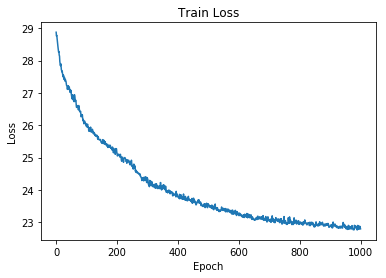

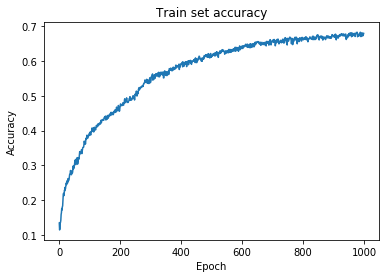

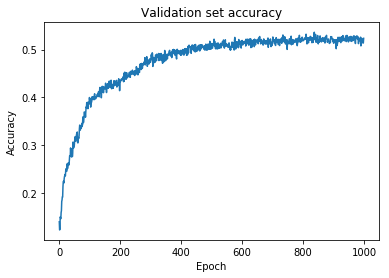

In [19]:
import matplotlib.pyplot as plt

plt.plot(history_epoch, history_train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.savefig('log/train_loss.png')
plt.show()

plt.plot(history_epoch, history_train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train set accuracy')
plt.savefig('log/train_accuracy.png')
plt.show()

plt.plot(history_epoch, history_validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation set accuracy')
plt.savefig('log/validation_accuracy.png')
plt.show()

# Test network

11
11


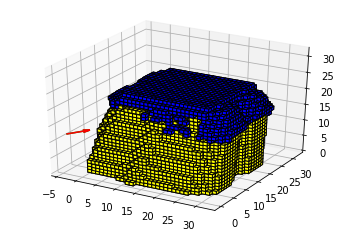

6
6


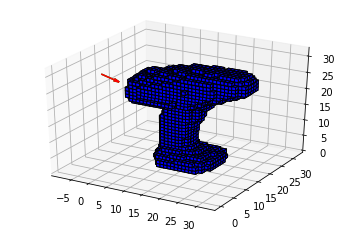

7
7


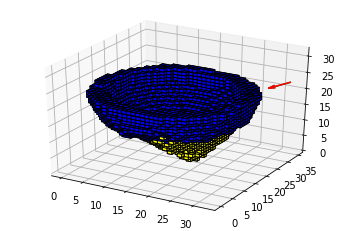

In [20]:
# returns: test images, test predicted keypoints, test ground truth keypoints
test_grids, test_outputs, gt_nbvs = net_sample_output()
visualize_output(test_grids, test_outputs, np.squeeze(gt_nbvs))

In [21]:
# save parameters
torch.save(net.state_dict(), saving_weights_file)

In [22]:
# save metrics

np.save('log/train_loss', history_train_loss)
np.save('log/validation_loss', history_validation_loss)
np.save('log/train_accuracy', history_train_accuracy)
np.save('log/validation_accuracy', history_validation_accuracy)